In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from scipy.signal import find_peaks, peak_prominences
import functions
import os
from tqdm.auto import tqdm
from scipy import stats
import seaborn as sns

In [2]:
from stardist.models import StarDist2D 
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [3]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

In [4]:
def traces_from_video(video, img, prob_thresh=0.479071):
    #stardist segentation
    labels, _ = model.predict_instances(normalize(img), prob_thresh=prob_thresh)
    # get traces for each roi from video
    rois = functions.get_traces(video, labels)
    # normalize
    traces = functions.deltanorm(rois)
    return traces, labels

In [5]:
def ratio_reaction(traces):
    counter = 0
    for i in traces.columns:
        signal = traces[i]
        filtered = functions.wavelet_transform(signal)
        # adjust for trace variability (traces with very small values would otherwise have too high values and be counted as reacting)
        derivative = np.diff(filtered)/signal[0:300].var()
        peaks, peak_heights = find_peaks(derivative, prominence=6)
        if np.any(np.array(peaks)>300):
            counter += 1
    ratio_reacting_cells = counter/len(traces.columns)
    return ratio_reacting_cells

In [6]:
def get_ratios(red_video_path, calcium_video_path):
    # read videos
    red_video = functions.read_video(red_video_path)
    calcium_video = functions.read_video(calcium_video_path)
    # create image of mean of video
    red_img = red_video.mean(axis=0)
    calcium_img = calcium_video.mean(axis=0)
    
    # get calcium signals of infected cells
    traces_inf, labels_red = traces_from_video(calcium_video, red_img)
    # determine ratio of reacting cells
    ratio_reaction_inf = ratio_reaction(traces_inf)
    
    # get calcium signals of non-infected cells
    deleted_rois_img = calcium_img
    deleted_rois_img[labels_red>0] = 0
    traces_no_inf, labels_no_red = traces_from_video(calcium_video, deleted_rois_img, prob_thresh=0.3)
    # determine ratio of reacting cells
    ratio_reaction_no_inf = ratio_reaction(traces_no_inf)
    
    return ratio_reaction_inf, ratio_reaction_no_inf

In [7]:
path = 'D:/Lab/CI-1063'

In [8]:
dsred_video_path = os.path.join(path,'dsRed')
caps_video_path = os.path.join(path,'Caps')
aitc_video_path = os.path.join(path,'AITC')
dsred_video_filenames = os.listdir(dsred_video_path)
caps_video_filenames = os.listdir(caps_video_path)
aitc_video_filenames = os.listdir(aitc_video_path)

caps_ratios_inf = []
caps_ratios_no_inf = []
aitc_ratios_inf = []
aitc_ratios_no_inf = []

for dsred_filename in tqdm(dsred_video_filenames):
    # get and match filenames
    caps_filename = dsred_filename[:11]+'Caps'+dsred_filename[16:]
    aitc_filename = dsred_filename[:11]+'AITC'+dsred_filename[16:]
    dsred_dir = os.path.join(dsred_video_path, dsred_filename)
    
    if caps_filename in caps_video_filenames:
        caps_dir = os.path.join(caps_video_path, caps_filename)
        # get values for infected and not infected cells
        ratio_inf, ratio_no_inf = get_ratios(dsred_dir, caps_dir)
        # append values to result list
        caps_ratios_inf.append(ratio_inf)
        caps_ratios_no_inf.append(ratio_no_inf)
    
    if aitc_filename in aitc_video_filenames:
        aitc_dir = os.path.join(aitc_video_path, aitc_filename)
        # get values for infected and not infected cells
        ratio_inf, ratio_no_inf = get_ratios(dsred_dir, aitc_dir)
        # append values to result list
        aitc_ratios_inf.append(ratio_inf)
        aitc_ratios_no_inf.append(ratio_no_inf)

  0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
def statistic(group_a_data, group_b_data):
    statistic, p_value_a = stats.shapiro(group_a_data)
    statistic, p_value_b = stats.shapiro(group_b_data)
    
    if (p_value_b < 0.05) or (p_value_a < 0.05):
        # data is not normally distrubuted (<0.05)
        statistic, p_value = stats.mannwhitneyu(group_a_data, group_b_data, alternative='two-sided')
        print('Mann Whitney U: p-value='+"{:.5f}".format(p_value))
    else:
        # data is normally distributed
        # test for equal variance
        statistic, p_value = stats.bartlett(group_a_data, group_b_data)
        if p_value < 0.05:
            # no equal variance
            equal_variance = False
            print('Welch-test')
        else: 
            equal_variance = True
            print('t-test')
        # perform t-test
        statistic, p_value = stats.ttest_ind(group_a_data, group_b_data, equal_var=equal_variance, nan_policy='omit')
        print('p-value='+"{:.5f}".format(p_value))

In [49]:
def quick_plot(group_a_data, group_b_data, feature): 
    
    statistic(group_a_data, group_b_data)
    
    plt.figure(figsize=(6,8))
    standard_props = {"color":'k', "linewidth":5}
    bbox_props = {**standard_props, 'facecolor': 'w', 'edgecolor':'k'}
    median_props = standard_props
    cap_props = standard_props
    line_props = standard_props
    sns.boxplot(data=[group_a_data, group_b_data], width=0.6, fliersize=0, whiskerprops=line_props, boxprops=bbox_props,capprops=cap_props, medianprops=median_props)
    sns.stripplot(data=[group_a_data, group_b_data], jitter=0.2, dodge=True, size=10, marker='o')
    
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(length=10, width=5)
    ax.set_ylim([-1, 101])
    plt.yticks(fontname="Arial", fontsize=30)
    
    ax.set_xticklabels(['not infected', 'infected'], fontsize=32, fontname = 'Arial')    
    plt.ylabel(feature, fontsize=32)
    plt.savefig(feature+'.png', bbox_inches = "tight")
    plt.show()

Welch-test
p-value=0.00005


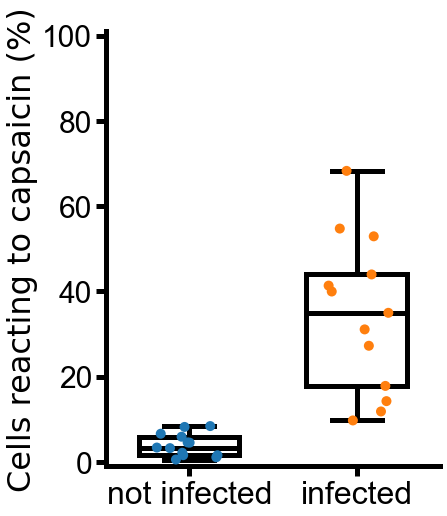

In [50]:
quick_plot(np.array(caps_ratios_no_inf)*100, np.array(caps_ratios_inf)*100, 'Cells reacting to capsaicin (%)')

Welch-test
p-value=0.03399


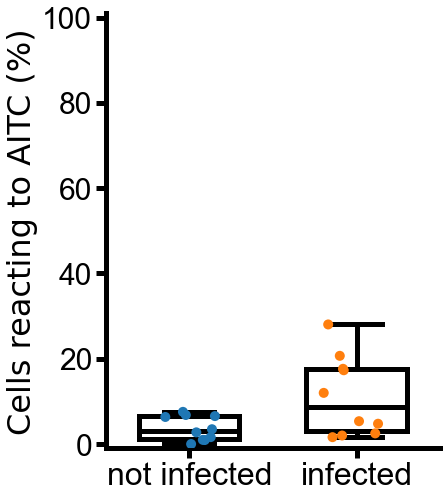

In [51]:
quick_plot(np.array(aitc_ratios_no_inf)*100, np.array(aitc_ratios_inf)*100, 'Cells reacting to AITC (%)')